In [1]:
import acoular
import matplotlib.pyplot as pl
import ipywidgets as ipw
import numpy as np
from glob import glob
from os import path
import pylab as plt
import math as m
import os
from matplotlib import font_manager as fm, rcParams
import scipy as sc


In [2]:
#Einlesen der Micgeo
micgeofile = 'mic_geo.xml'
mg = acoular.MicGeom(from_file=micgeofile)
mg.mpos[0] = - mg.mpos[0] #Spiegeln
mg.mpos[0] = mg.mpos[0] + 0.419 #Versatz
#print(mg.mpos)

#Rotationsmatrix
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

for i in range (64):
    Punkt = [mg.mpos[0][i],mg.mpos[1][i],mg.mpos[2][i]]
    rot = np.array(Punkt * Rx(np.radians(-45)))
    #print(rot[0][0])
    mg.mpos[0][i] = rot[0][0]
    mg.mpos[1][i] = rot[0][1]
    mg.mpos[2][i] = rot[0][2]
mg.mpos[1] = - mg.mpos[1]

#plt.ion()
#plt.plot(mg.mpos[2],mg.mpos[1],'o')

t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))


In [3]:
# Messung 13
sfreq = 51200
duration = 1
nsamples = duration*sfreq

sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)
sim_signal2 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2)

#sim_ts1 = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
#                   loc = (7.5, 0.2, 8.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
#                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
#                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
sim_ts2 = acoular.PointSource(signal = sim_signal2,          # Signal der Quelle
                   #loc = (-5.0, 0.2, 8),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   loc = (1, 0.2, 2),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
#ts = acoular.SourceMixer( sources=[sim_ts1,sim_ts2])
ts = sim_ts2 

Einlesen der Daten:

In [4]:
# Umgebung definieren (Medium, Strömung etc)

#Einlesen der Daten:
ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
#ts = acoular.TimeSamples( name='Messungen_WFS/msm_013.h5' )
#ts = acoular.TimeSamples( name='Messungen_WFS/msm_025.h5' )


#Grid erstellen


#============== Messung 1,2,3,4,5,15,16,17,18,19,20,23,24,25,36,27,28 ==============
rg = acoular.RectGrid( x_min=-3, x_max=3.0, 
                       y_min=-3.0, y_max=3.0, 
                       z=2, 
                       increment=0.01 )          

#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=512, # Gert empfiehlt ab 4096
                           freq_range=[600, 5000],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )




In [11]:
Frequenz = 1500
tolerance = 15

pm = bb.synthetic(Frequenz, 3) # 0=Freq, 1=Okt, 3=Terz
Lm = acoular.L_p(pm)
Lm_rot = np.rot90(Lm)#rotiert Lm um 90 Grad

Lm_max = sc.signal.argrelmax(Lm)
Lm_rot_max = sc.signal.argrelmax(Lm_rot)


max_values = []
for i in range (len(Lm_max[0])):
    max_value = Lm[Lm_max[0][i]][Lm_max[1][i]]

    if (max_value >= np.amax(Lm.T) - tolerance):
        max_values.append(max_value)
max_values = np.array(max_values)

max_values_rot = []
for i in range (len(Lm_rot_max[0])):
    max_value_rot = Lm_rot[Lm_rot_max[0][i]][Lm_rot_max[1][i]]

    if (max_value_rot >= np.amax(Lm.T) - tolerance):
        max_values_rot.append(max_value_rot)
max_values_rot = np.array(max_values_rot)

max_pegel = []
for i in range (len(max_values)):
    
    if (max_values[i] in max_values_rot):
        max_pegel.append(max_values[i])
max_pegel = np.sort(max_pegel)      
max_pegel = max_pegel[::-1]
'''
max_values_index = sc.signal.argrelmax(max_values)
max_values_index = np.array(max_values_index)
max_values_index = max_values_index.flatten()

max_values_index_rot = sc.signal.argrelmax(max_values_rot)
max_values_index_rot = np.array(max_values_index_rot)
max_values_index_rot = max_values_index_rot.flatten()
'''
print(max_pegel)

[60.95356242 57.46000563 52.77277974 51.30508978 49.09241878 48.4107019
 48.23847064 47.4839509  47.23572312 46.90594444]


[-0.11]
[0.17]
[-0.13]
[-2.19]
[-0.13]
[-1.03]
[-0.11]
[0.7]
[-1.01]
[1.66]
[-2.67]
[0.14]
[-1.61]
[0.14]
[0.57]
[2.78]
[-0.15]
[-0.26]
[1.97]
[1.05]


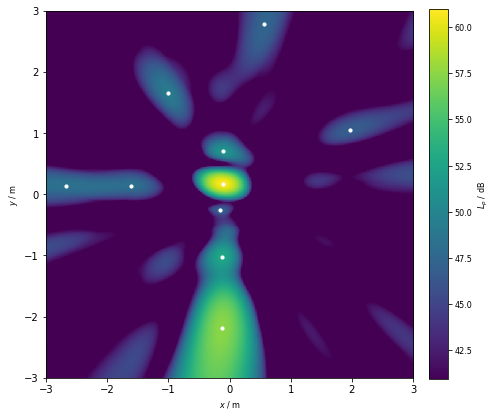

In [12]:
FONTSIZE = 8
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))

im = ax1.imshow(Lm.T, 
            origin='lower', 
            vmin=Lm.max()-20, 
            extent=rg.extend(), 
            interpolation='nearest')  # bicubic vs nearest? -> bicubic beschoenigt

ax1.set_xticks([-3,-2,-1,0,1,2,3])
ax1.set_yticks([-3,-2,-1,0,1,2,3])
ax1.set_xlabel('$x$ / m',fontsize=FONTSIZE)
ax1.set_ylabel('$y$ / m',fontsize=FONTSIZE)
cbar = fig.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=FONTSIZE)
cbar.set_label('$L_p$ / dB', fontsize=FONTSIZE)

'''
for i in range(len(max_values)):
    ax1.scatter(np.where(Lm.T == max_values[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm.T == max_values[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2), color='red', s = 5)
for i in range(len(max_values_rot)):
    ax1.scatter(np.where(Lm.T == max_values_rot[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm.T == max_values_rot[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2), color='white', s = 5)
'''
for i in range(len(max_pegel)):
    ax1.scatter(np.where(Lm.T == max_pegel[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2),np.where(Lm.T == max_pegel[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2), color='white', s = 10)
    print(np.where(Lm.T == max_pegel[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2))
    print(np.where(Lm.T == max_pegel[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2))
fig.tight_layout()
#plt.savefig('Plots/Abstract/%s_terz5000Hz.pdf'%ts.name[14:21], dpi = 300, format='pdf')
#plt.savefig('Plots/Abstract/013_terz1600Hz_simuliert.pdf', dpi = 300, format='pdf')


In [40]:
'''
def get_euclidian_dist(x1,y1,x2,y2):
    euclidian_dist = np.sqrt((x2-x1)**2+(y2-y1)**2)
    return euclidian_dist


for i in range (len(max_values)):
    max_index_x.append(np.where(Lm.T == max_values[i])[1])
    max_index_y.append(np.where(Lm.T == max_values[i])[0])
    max_coord_x.append(np.where(Lm.T == max_values[i])[1]*rg.increment-((rg.x_max-rg.x_min)/2))
    max_coord_y.append(np.where(Lm.T == max_values[i])[0]*rg.increment-((rg.y_max-rg.y_min)/2))
max_index_x = np.array(max_index_x)
max_index_y = np.array(max_index_y)
max_coord_x = np.array(max_coord_x)
max_coord_y = np.array(max_coord_y)
cluster = []
for j in range (len(max_index_x)):
    point_cluster = []
        
    for i in range (len(max_index_x)):
        eucl_tolerance = rg.increment * 5
        #print(get_euclidian_dist(max_coord_x[0],max_coord_y[0],max_coord_x[i+1],max_coord_y[i+1]))
        if (get_euclidian_dist(max_coord_x[j],max_coord_y[j],max_coord_x[i],max_coord_y[i]) <= eucl_tolerance):
            point_cluster.append(i)

    cluster.append(point_cluster)
#print(cluster)
'''

In [8]:
for z in range (len(cluster)-1):
    for i in cluster[z]:
        for j in cluster[z+1]:
            if(cluster[z][len(cluster[z])] in cluster[z+1]):
                print(cluster[z][len(cluster[z])])
                break
        

IndexError: list index out of range

In [33]:
test_list_1 = [1,2,3,4,5,6,7,8]
test_list_2 = [12,13,14,15,5,8,17,21,54,23]
test_list_same = []
for i in range (len(test_list_1)):
    
    
    

    if (test_list_1[i] in test_list_2):
        test_list_same.append(test_list_1[i])
        
print(test_list_same)

[5, 8]


In [34]:
max_pegel = []
for i in range (len(max_values)):
    
    if (max_values[i] in max_values_rot):
        max_pegel.append(max_values[i]) 
            
print(max_pegel)

    



[56.21491214999683, 56.321532584962256, 56.31521248861789, 57.76258359873896, 57.775625931610165, 57.78485834434597, 57.78999924336922, 57.79075362658485, 56.6864882219804, 58.297400243499496, 71.16879151169775, 59.18778965116712]


In [ ]:
#np.max(Lm[Lm_max[0]][Lm_max[1]].T)
Lm[400][350].T
#Lm_max = np.array(Lm_max)
#print(len(Lm_max[0]))
max_values = []
tolerance = 10

for i in range (len(Lm_max[0])):
    max_value = Lm[Lm_max[0][i]][Lm_max[1][i]]

    if (max_value >= np.amax(Lm.T) - tolerance):
        max_values.append(max_value)


#max_values = np.array(max_values)
#max_values

In [ ]:
# Umgebung definieren (Medium, Strömung etc)
t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))

#Einlesen der Daten:
#ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
ts = acoular.TimeSamples( name='Messungen_WFS/msm_015.h5' )


#Grid erstellen
rg = acoular.RectGrid3D(x_min=-2, x_max=2, 
                       y_min=0, y_max=0, 
                       z_min=1, z_max=5, 
                       increment=0.01)

#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'classic') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=128,
                           freq_range=[20, 4000],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )

Exception occurred in traits notification handler for object: <acoular.sources.TimeSamples object at 0x0000023254677C20>, trait: basename, old value: None, new value: msm_015
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\traits\trait_notifiers.py", line 524, in _dispatch_change_event
    self.dispatch(handler, *args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\traits\trait_notifiers.py", line 486, in dispatch
    handler(*args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\acoular\sources.py", line 140, in load_data
    raise IOError("No such file: %s" % self.name)
OSError: No such file: Messungen_WFS/msm_015.h5
Exception occurred in traits notification handler for object: <acoular.spectra.PowerSpectra object at 0x0000023261046A40>, trait: _freqlc, old value: 0, new value: 20.0
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\traits\trait_notifiers.py", line 524, in _dispatch_change_event
    self.

In [ ]:
# 500 1000 2000
# 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300 8000 10000 12500 16000 20000

Frequenz = 2000

pm = bb.synthetic(Frequenz, 3) # 0=Freq, 1=Okt, 3=Terz
Lm2 = acoular.L_p( pm )
Lm2 = Lm2[:,0,:]
#Lm = (Lm[0:],Lm[1:])
plt.figure()
plt.imshow( Lm2.T, 
            origin='lower', 
            #vmin=Lm.max()-10, 
            #extent=rg.extend(), 
            interpolation='nearest')  # bicubic vs nearest? -> bicubic beschoenigt
plt.colorbar()
#plt.savefig('Plots/%s_terz10000Hz'%ts.name[14:21], dpi = 300, format='png')
plt.show()

ZeroDivisionError: float division by zero

In [ ]:
Lm2 = Lm2[:,0,:]
Lm2.shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:

'''
map_z = sum(pm,2)
map_y = sum(pm,1)
map_x = sum(pm,0)

plt.figure()
plt.imshow( map_x.T, 
            origin='lower', 
            vmin=Lm.max()-10, 
            extent=rg.extend(), 
            interpolation='bicubic')  # bicubic vs nearest?
plt.colorbar()
#plt.savefig('Plots/%s_okt_1600'%ts.name[14:21], dpi = 300, format='png')
plt.show()

'''

a = np.array([[0,1,2,3,4],[00,11,22,33,44]])
b = (a[:,4],a[:,2])


TypeError: Cannot construct a dtype from an array

In [ ]:
from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel

b = acoular.BeamformerCleansc(freq_data=ps, steer=st)

g = acoular.RectGrid3D(x_min=-0.5, x_max=0.5, 
                       y_min=-0.5, y_max=0.5, 
                       z_min=1.5, z_max=2.5, 
                       increment=0.02)

map = b.synthetic(2000,1)

<ipython-input-75-858483a2851c>:1: Warning: Queried frequency (1500 Hz) not in set of discrete FFT sample frequencies. Using frequency 1600 Hz instead.
  map = bb.synthetic(1500, 0)


TypeError: Invalid shape (401,) for image data

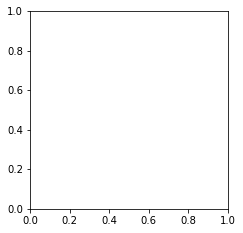

In [ ]:
map = bb.synthetic(1500, 0)
fig=figure(1,(8,8))

subplot(221)
map_z = sum(map,0)
mx = L_p(map_z.max())
imshow(L_p(map_z.T), vmax=mx, vmin=mx-20, origin='lower', interpolation='nearest', 
       extent=(g.x_min, g.x_max, g.y_min, g.y_max))
xlabel('x')
ylabel('y')
title('Top view (xy)' )

subplot(223)
map_y = sum(map,1)
imshow(L_p(map_y.T), vmax=mx, vmin=mx-20, origin='upper', interpolation='nearest', 
       extent=(g.x_min, g.x_max, -g.z_max, -g.z_min))
xlabel('x')
ylabel('z')
title('Side view (xz)' )

subplot(222)
map_x = sum(map,0)
imshow(L_p(map_x), vmax=mx, vmin=mx-20, origin='lower', interpolation='nearest', 
       extent=(-g.z_min, -g.z_max,g.y_min, g.y_max))
xlabel('z')
ylabel('y')
title('Side view (zy)' )
colorbar()

In [ ]:
ax0 = fig.add_subplot((224), projection='3d')
ax0.scatter(mg.mpos[0],mg.mpos[1],-mg.mpos[2])
#source_locs=array([p1.loc,p2.loc,p3.loc]).T
#ax0.scatter(source_locs[0],source_locs[1],-source_locs[2])
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax0.set_title('Setup (mic and source positions)')
#plt.show()

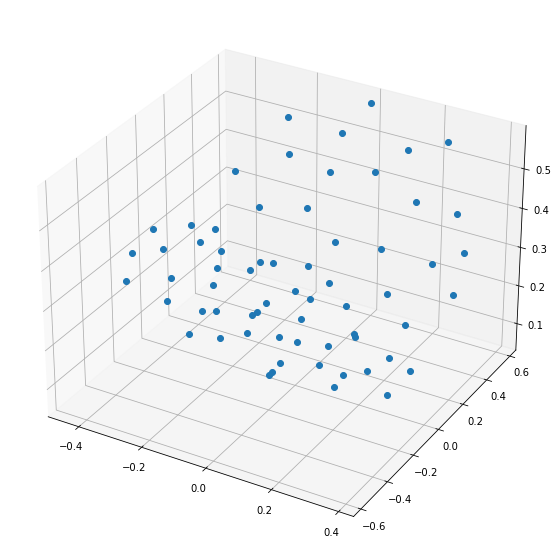

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10),sharey=True)
ax = plt.axes(projection='3d')
ax.plot3D(mg.mpos[0], mg.mpos[1], mg.mpos[2], 'o')

<ipython-input-78-4423b32eef9d>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


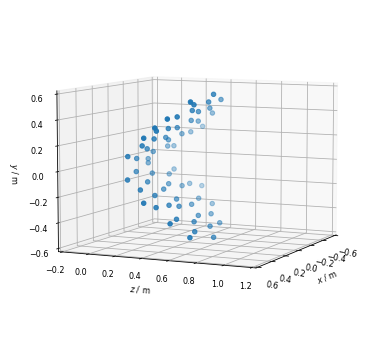

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6),sharey=True)
ax = plt.axes(projection='3d')
ax.scatter(mg.mpos[0], mg.mpos[2], mg.mpos[1])
ax.view_init(7, 25)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.2,1.2)
ax.set_zlim(-0.6,0.6)
ax.set_xlabel('$x$ / m',fontsize=FONTSIZE)
ax.set_ylabel('$z$ / m',fontsize=FONTSIZE)
ax.set_zlabel('$y$ / m',fontsize=FONTSIZE)
ax.tick_params(axis='x', labelsize=FONTSIZE, rotation =350) 
ax.tick_params(axis='y', labelsize=FONTSIZE) 
ax.tick_params(axis='z', labelsize=FONTSIZE) 
fig.show()
#fig.tight_layout()
plt.savefig('Plots/Abstract/micpos.pdf', dpi = 300, format='pdf')